<a href="https://colab.research.google.com/github/MateusRsousa/Classificacao_nivel_glicemico_PPG/blob/main/PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir
!pip install --force-reinstall --no-cache-dir pandas


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 206.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 139.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 255.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 244.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 243.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 318.1

In [ ]:


import os
import pandas as pd
import numpy as np
import heartpy as hp
from scipy.signal import butter, filtfilt, savgol_filter
from scipy.stats import kurtosis, skew
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt








In [ ]:
from sklearn.model_selection import train_test_split

**CARREGAR DADOS**

In [ ]:
# Montar o Google Drive
drive.mount('/content/drive')

# Função para carregar os dados de PPG dos pacientes
def load_ppg_data(folder_path):
    ppg_data = {}
    for patient_folder in sorted(os.listdir(folder_path)):
        patient_path = os.path.join(folder_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_wave.csv'):  # Processar apenas arquivos que terminam com '_wave.csv'
                    file_path = os.path.join(patient_path, file)
                    ppg_wave = pd.read_csv(file_path)['Wave']
                    ppg_data[patient_folder] = ppg_wave
    return ppg_data




# Carregar os dados de glicose (alta ou baixa) a partir do arquivo Excel
glicose_data_path = '/content/drive/My Drive/PPG_IEB/dados_estruturados.xlsx'
glicose_data = pd.read_excel(glicose_data_path)

# Criar um dicionário para mapear o ID do paciente (coluna 'Participante') à coluna 'Grupo'
glicose_dict = glicose_data.set_index('Participante')['Grupo'].apply(lambda x: 1 if x == 'D' else 0).to_dict()

# Ajustar os IDs de PPG para ter o mesmo formato dos IDs de glicose (adicionando o prefixo '#')
def format_ppg_id(patient_id):
    return f"#{patient_id.zfill(3)}"  # Garante que o ID tenha 3 dígitos e o prefixo '#'

# Caminho para a pasta com os dados PPG
ppg_folder_path = '/content/drive/My Drive/PPG_IEB/'

# Carregar os dados de PPG
ppg_data = load_ppg_data(ppg_folder_path)



ppg_data_train, ppg_data_test = train_test_split(ppg_data, test_size=0.1, random_state=42)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: np.int64(83)

**FILTROS**

In [ ]:
def savitzky_golay_filter(data, window_length=11, polyorder=3):
    # Garantir que window_length seja ímpar e menor que o tamanho do sinal
    if window_length % 2 == 0:
        window_length += 1
    if window_length > len(data):
        window_length = len(data) - (len(data) % 2) - 1  # Ajustar para ser ímpar e menor que o tamanho do sinal
    # Aplicar o filtro
    filtered_data = savgol_filter(data, window_length=window_length, polyorder=polyorder)
    return filtered_data  # Retorna numpy.ndarray

# Função para aplicar o filtro Butterworth Bandpass
def butterworth_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data  # Retorna numpy.ndarray

# Função para aplicar a normalização Min-Max
def min_max_normalization(data):
    data_min = np.min(data)
    data_max = np.max(data)
    if data_max - data_min == 0:
        normalized_data = data - data_min  # Retorna zeros
    else:
        normalized_data = (data - data_min) / (data_max - data_min)
    return normalized_data  # Retorna numpy.ndarray

# Função para extrair características dos sinais PPG (média e variância)

# Função de cálculo dos parâmetros de Hjorth
def hjorth_parameters(signal):
    """Calcula mobilidade e complexidade de Hjorth."""
    first_derivative = np.diff(signal)  # Primeira derivada do sinal
    mobility = np.std(first_derivative) / np.std(signal)  # Mobilidade
    second_derivative = np.diff(first_derivative)  # Segunda derivada
    complexity = np.std(second_derivative) / np.std(first_derivative)  # Complexidade
    return mobility, complexity

# Função para calcular a entropia de amostra
def sample_entropy(signal):
    """Calcula a entropia de amostra."""
    n = len(signal)
    r = 0.2 * np.std(signal)
    A = sum([np.abs(signal[i] - signal[i+1]) < r for i in range(n-1)])
    B = sum([np.abs(signal[i] - signal[i+2]) < r for i in range(n-2)])
    return -np.log(A/B) if B != 0 else 0

# Função para calcular a energia do sinal
def signal_energy(signal):
    """Calcula a energia do sinal."""
    return np.sum(np.square(signal))

# Função para calcular a frequência cardíaca média
def heart_rate(peaks, sampling_rate):
    rr_intervals = np.diff(peaks) / sampling_rate  # Intervalos entre batimentos em segundos
    hr = 60.0 / np.mean(rr_intervals)  # Convertendo para batimentos por minuto
    return hr

# Função para calcular o tempo médio entre picos (RR intervals)
def mean_rr_interval(peaks, sampling_rate):
    rr_intervals = np.diff(peaks) / sampling_rate  # Intervalos entre picos em segundos
    return np.mean(rr_intervals)

# Função para calcular o tempo de subida e descida do sinal
def rise_fall_time(segment):
    diff_signal = np.diff(segment)
    rise_time = np.sum(diff_signal > 0)
    fall_time = np.sum(diff_signal < 0)
    return rise_time, fall_time

**COMPARANDO FILTROS**

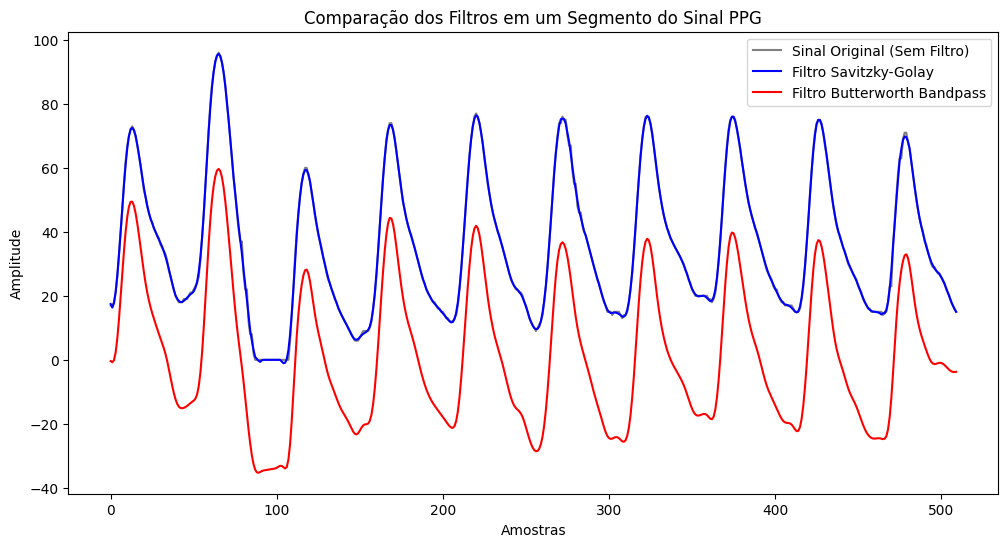

In [ ]:
# Selecionar um paciente e carregar seu sinal PPG
patient_id = list(ppg_data.keys())[0]  # Seleciona o primeiro paciente da lista
ppg_wave = ppg_data[patient_id]

# Certificar-se de que ppg_wave é um numpy.ndarray
if isinstance(ppg_wave, pd.Series):
    ppg_wave = ppg_wave.values

# Definir a taxa de amostragem
sampling_rate = 100  # Hz

# Aplicar o filtro Butterworth Bandpass ao sinal completo
filtered_ppg_butterworth = butterworth_bandpass_filter(ppg_wave, lowcut=0.5, highcut=15, fs=sampling_rate, order=6)

# Aplicar o filtro Savitzky-Golay ao sinal completo
filtered_ppg_savgol = savitzky_golay_filter(ppg_wave)

# Processar o sinal filtrado para obter picos e mínimos
wd_butter, _ = hp.process(filtered_ppg_butterworth, sampling_rate)
peaks_butter = np.array(wd_butter['peaklist'])
wd_inv_butter, _ = hp.process(-filtered_ppg_butterworth, sampling_rate)
minima_butter = np.array(wd_inv_butter['peaklist'])

# Selecionar um segmento do sinal filtrado pelo Butterworth
segments_butter = []
segment_indices = []

for i in range(0, len(peaks_butter) - 9, 10):
    start_min_candidates = minima_butter[minima_butter < peaks_butter[i]]
    end_min_candidates = minima_butter[minima_butter > peaks_butter[i + 9]]

    if len(start_min_candidates) > 0 and len(end_min_candidates) > 0:
        start_min = start_min_candidates[-1]
        end_min = end_min_candidates[0]
        segment_butter = filtered_ppg_butterworth[start_min:end_min]
        segments_butter.append(segment_butter)
        segment_indices.append((start_min, end_min))

# Verificar se temos segmentos disponíveis
if len(segments_butter) == 0:
    print("Não foram encontrados segmentos suficientes para o paciente selecionado.")
else:
    # Selecionar o primeiro segmento
    segment_butter = segments_butter[0]
    start_min, end_min = segment_indices[0]

    # Extrair o segmento correspondente do sinal original
    segment_original = ppg_wave[start_min:end_min]

    # Aplicar os filtros ao segmento do sinal original
    segment_savgol = savitzky_golay_filter(segment_original)
    segment_butter_segment = butterworth_bandpass_filter(segment_original, lowcut=0.5, highcut=15, fs=sampling_rate, order=4)

    # Plotar os sinais
    plt.figure(figsize=(12, 6))
    plt.plot(segment_original, label='Sinal Original (Sem Filtro)', color='gray')
    plt.plot(segment_savgol, label='Filtro Savitzky-Golay', color='blue')
    plt.plot(segment_butter_segment, label='Filtro Butterworth Bandpass', color='red')
    plt.legend()
    plt.title('Comparação dos Filtros em um Segmento do Sinal PPG')
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude')
    plt.show()

**CONFIGURAÇÃO DE FEATURES**

92
Processando paciente #001...
Processando paciente #002...
Processando paciente #003...
Processando paciente #004...
Processando paciente #005...
Processando paciente #006...
Processando paciente #007...
Processando paciente #008...
Processando paciente #009...
Processando paciente #010...
Processando paciente #011...
Processando paciente #012...
Processando paciente #013...
Processando paciente #014...
Processando paciente #015...
Processando paciente #016...
Processando paciente #017...
Processando paciente #018...
Processando paciente #019...
Processando paciente #020...
Processando paciente #021...
Processando paciente #022...
Processando paciente #023...
Processando paciente #024...
Processando paciente #025...
Processando paciente #026...
Processando paciente #027...
Processando paciente #028...
Processando paciente #029...
Processando paciente #030...
Processando paciente #031...
Processando paciente #032...
Processando paciente #033...
Processando paciente #034...
Processando

/usr/local/lib/python3.11/dist-packages/heartpy/analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


Processando paciente #086...
Processando paciente #087...
Processando paciente #088...
Processando paciente #089...
Processando paciente #090...
Processando paciente #091...
Processando paciente #092...
     Patient_ID    Std_Dev  Kurtosis      Skew   Entropy         Energy  \
0          #001  21.392527 -0.841014  0.595038 -0.348901  232946.103732   
1          #001  18.757732 -0.939416  0.602076 -0.346357  181908.237983   
2          #001  17.845066 -0.981610  0.605367 -0.356348  165616.354012   
3          #001  18.394290 -1.036751  0.549693 -0.382685  173911.855696   
4          #001  18.396965 -1.028108  0.548392 -0.382528  174300.931411   
...         ...        ...       ...       ...       ...            ...   
6463       #092  12.975362 -0.821449  0.663157 -0.279271  100007.266988   
6464       #092  12.943835 -0.817327  0.661816 -0.300003   96002.100582   
6465       #092  13.093942 -0.777708  0.681110 -0.283017   99957.164328   
6466       #092  13.299233 -0.751107  0.682648 

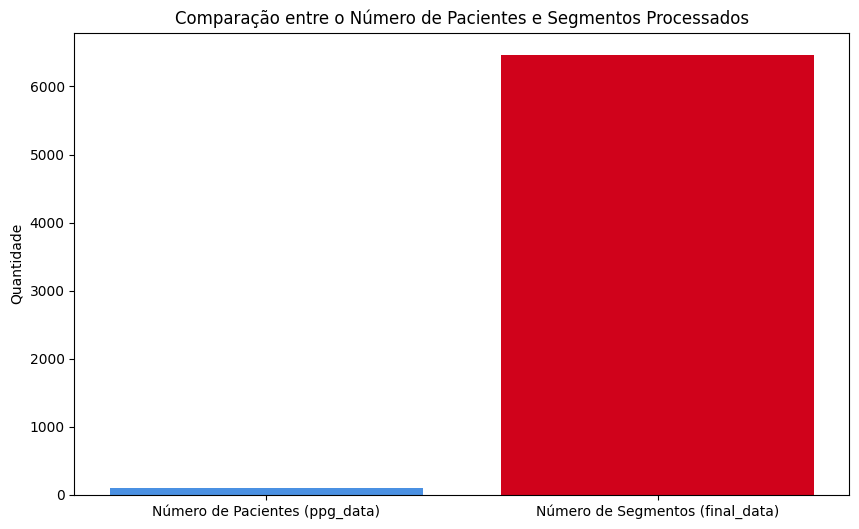

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def comparar_len_ppg_final(len_ppg_data, len_final_data):
    """
    Função para comparar o número de pacientes em `ppg_data` com o número de segmentos processados em `final_data`.

    Parâmetros:
        len_ppg_data (int): Número de pacientes em `ppg_data`.
        len_final_data (int): Número de segmentos processados em `final_data`.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(['Número de Pacientes (ppg_data)', 'Número de Segmentos (final_data)'],
            [len_ppg_data, len_final_data], color=['#4A90E2', '#D0021B'])
    plt.ylabel('Quantidade')
    plt.title('Comparação entre o Número de Pacientes e Segmentos Processados')
    plt.show()




# Função para processar um único sinal PPG e extrair as características
def process_ppg_signal(ppg_signal, sampling_rate=100, lowcut=1, highcut=10):
    filtered_ppg = butterworth_bandpass_filter(ppg_signal,lowcut,highcut, 100)

    # Processa o sinal para obter os picos e mínimos
    wd, _ = hp.process(filtered_ppg, sampling_rate)
    peaks = np.array(wd['peaklist'])
    wd, _ = hp.process(-filtered_ppg, sampling_rate)
    minima = np.array(wd['peaklist'])

    # Segmentação do sinal em grupos de 5 períodos
    segments = []
    for i in range(0, len(peaks) - 9, 5):
        start_min_candidates = minima[minima < peaks[i]]
        end_min_candidates = minima[minima > peaks[i + 9]]

        if len(start_min_candidates) > 0 and len(end_min_candidates) > 0:
            start_min = start_min_candidates[-1]
            end_min = end_min_candidates[0]
            segment = filtered_ppg[start_min:end_min]
            segments.append(segment)

    # Calcular frequência cardíaca e intervalo RR médio (usando todos os picos do sinal)
    heart_rate_avg = heart_rate(peaks, sampling_rate)
    rr_interval_avg = mean_rr_interval(peaks, sampling_rate)

    return segments, heart_rate_avg, rr_interval_avg

# Inicializa o DataFrame para armazenar os resultados
results = []

print(len(ppg_data))

# Processa cada sinal de PPG e extrai características
for patient_id, ppg_wave in ppg_data.items():
    formatted_id = format_ppg_id(patient_id)  # Ajustar o formato do ID do paciente
    print(f"Processando paciente {formatted_id}...")

    # Processar o sinal PPG para obter segmentos e frequências
    segments, heart_rate_avg, rr_interval_avg = process_ppg_signal(ppg_wave)

    # Adicionar a informação de glicose alta/baixa (1 para alta, 0 para baixa)
    glicose_alta = glicose_dict.get(formatted_id, None)  # None se o ID não for encontrado

    # Calcular características do sinal completo (fora do loop de segmentos)
    mediana_wave = ppg_wave.median()
    curtose_wave = ppg_wave.kurt()
    media_movel_wave = ppg_wave.rolling(window=5).mean().mean()
    assimetria_wave = ppg_wave.skew()
    desvio_padrao_wave = ppg_wave.std()
    media_wave = ppg_wave.mean()
    var_wave = ppg_wave.var()
    min_wave = ppg_wave.min()
    max_wave = ppg_wave.max()

    # Para cada segmento extraído, armazena as características no DataFrame
    for segment in segments:
        # Converter segmento para pandas Series se não for
        if not isinstance(segment, pd.Series):
            segment = pd.Series(segment)

        # Calcular características do segmento
        avg = segment.mean()
        std_dev = segment.std()
        kurt = kurtosis(segment)
        skewness = skew(segment)
        entropy = sample_entropy(segment)
        energy = signal_energy(segment)
        mobility, complexity = hjorth_parameters(segment)
        rise_time, fall_time = rise_fall_time(segment)

        # Calcular média da média móvel no segmento
        media_movel_segment = segment.rolling(window=5).mean().mean()

        result = {
            'Patient_ID': formatted_id,
            'Std_Dev': std_dev,
            'Kurtosis': kurt,
            'Skew': skewness,
            'Entropy': entropy,
            'Energy': energy,
            'Hjorth_Mobility': mobility,
            'Hjorth_Complexity': complexity,
            'Heart_Rate_Avg': heart_rate_avg,
            'RR_Interval_Avg': rr_interval_avg,
            'Rise_Time': rise_time,
            'Fall_Time': fall_time,
            'Glicose_Alta': glicose_alta,  # Adicionar a coluna de Glicose Alta/Baixa
            'mediana_wave': mediana_wave,  # Mediana do sinal completo
            'curtose_wave': curtose_wave,  # Curtose do sinal completo
            'media_movel_wave': media_movel_wave,  # Média da média móvel do sinal completo
            'assimetria_wave': assimetria_wave,  # Assimetria do sinal completo
            'desvio_padrao_wave': desvio_padrao_wave,  # Desvio padrão do sinal completo
            'media_wave': media_wave,  # Média do sinal completo
            'var_wave': var_wave,  # Variância do sinal completo
            'min_wave': min_wave,  # Valor mínimo do sinal completo
            'max_wave': max_wave   # Valor máximo do sinal completo
        }
        results.append(result)

# Convertendo os resultados em um DataFrame
final_data = pd.DataFrame(results)

# Exibindo o DataFrame com as características extraídas
print(final_data)
print(len(final_data))

# Salvando o DataFrame em um arquivo CSV
comparar_len_ppg_final(len(ppg_data), len(final_data))

final_data.to_csv('final_data.csv', index=False)

from google.colab import files
files.download('final_data.csv')


**TREINANDO O MODELO RANDOM FOREST**

In [ ]:
final_data

,Patient_ID,Std_Dev,Kurtosis,Skew,Entropy,Energy,Hjorth_Mobility,Hjorth_Complexity,Heart_Rate_Avg,RR_Interval_Avg,...,Glicose_Alta,mediana_wave,curtose_wave,media_movel_wave,assimetria_wave,desvio_padrao_wave,media_wave,var_wave,min_wave,max_wave
0,#001,21.392527,-0.841014,0.595038,-0.348901,232946.103732,0.153557,0.220971,116.261147,0.516080,...,1,35.0,0.171518,40.060535,0.740860,18.134925,40.059548,328.875491,0,127
1,#001,18.757732,-0.939416,0.602076,-0.346357,181908.237983,0.158066,0.228388,116.261147,0.516080,...,1,35.0,0.171518,40.060535,0.740860,18.134925,40.059548,328.875491,0,127
2,#001,17.845066,-0.981610,0.605367,-0.356348,165616.354012,0.156770,0.227952,116.261147,0.516080,...,1,35.0,0.171518,40.060535,0.740860,18.134925,40.059548,328.875491,0,127
3,#001,18.394290,-1.036751,0.549693,-0.382685,173911.855696,0.156026,0.221138,116.261147,0.516080,...,1,35.0,0.171518,40.060535,0.740860,18.134925,40.059548,328.875491,0,127
4,#001,18.396965,-1.028108,0.548392,-0.382528,174300.931411,0.156152,0.217962,116.261147,0.516080,...,1,35.0,0.171518,40.060535,0.740860,18.134925,40.059548,328.875491,0,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,#092,12.975362,-0.821449,0.663157,-0.279271,100007.266988,0.150430,0.232117,103.171059,0.581558,...,0,37.0,-0.251915,40.235110,0.668912,18.145723,40.237070,329.267247,0,105
6464,#092,12.943835,-0.817327,0.661816,-0.300003,96002.100582,0.153823,0.231863,103.171059,0.581558,...,0,37.0,-0.251915,40.235110,0.668912,18.145723,40.237070,329.267247,0,105
6465,#092,13.093942,-0.777708,0.681110,-0.283017,99957.164328,0.152902,0.235393,103.171059,0.581558,...,0,37.0,-0.251915,40.235110,0.668912,18.145723,40.237070,329.267247,0,105
6466,#092,13.299233,-0.751107,0.682648,-0.260506,101700.337438,0.156138,0.237746,103.171059,0.581558,...,0,37.0,-0.251915,40.235110,0.668912,18.145723,40.237070,329.267247,0,105


Acurácia do modelo Naive Bayes: 49.39%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Balanced Accuracy Logistic Regression: 57.50%
Acurácia balanceada para k-NN: 51.25%
Balanced Accuracy Random Forest: 46.60%


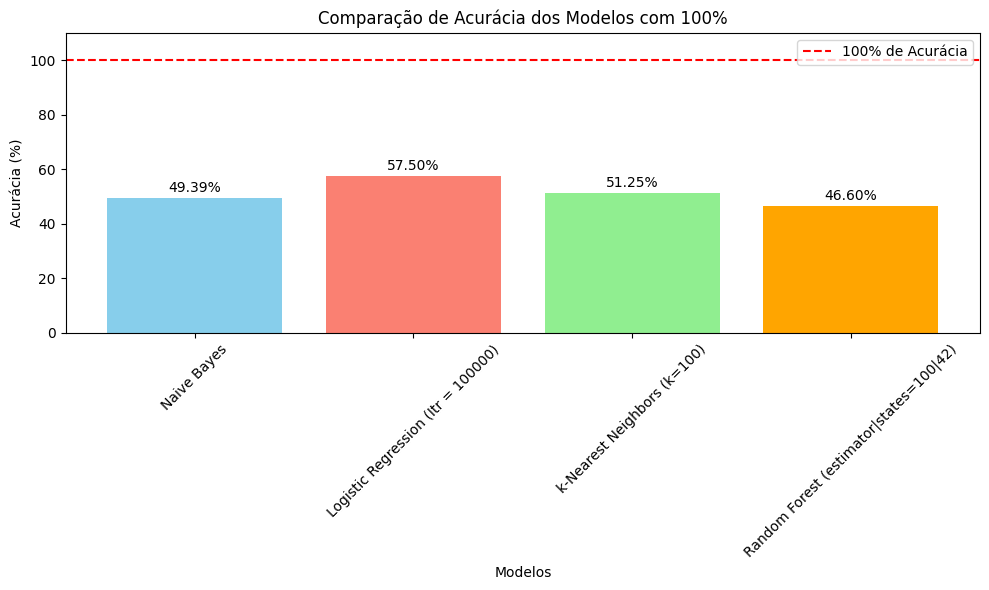

In [ ]:

# Função para criar o gráfico de barras comparando cada modelo ao 100%
def plot_model_accuracy_vs_100(model_accuracies):
    models = list(model_accuracies.keys())
    accuracies = [acc * 100 for acc in model_accuracies.values()]  # Converte para porcentagem

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'orange'])
    plt.axhline(100, color='red', linestyle='--', label='100% de Acurácia')
    plt.xlabel("Modelos")
    plt.ylabel("Acurácia (%)")
    plt.title("Comparação de Acurácia dos Modelos com 100%")
    plt.ylim(0, 110)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Exibe valores no topo de cada barra para melhor visualização
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    plt.show()


# Separação baseada nos pacientes (sem repetir pacientes em treino e teste)
unique_patients = final_data['Patient_ID'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)

# Selecionar dados de treino e teste com base no Patient_ID
train_data = final_data[final_data['Patient_ID'].isin(train_patients)]
test_data = final_data[final_data['Patient_ID'].isin(test_patients)]

# Separar X e y
X_train = train_data.drop(['Glicose_Alta', 'Patient_ID'], axis=1)
y_train = train_data['Glicose_Alta']
X_test = test_data.drop(['Glicose_Alta', 'Patient_ID'], axis=1)
y_test = test_data['Glicose_Alta']

# Treinar modelo Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

accuracy_nb = model_nb.score(X_test, y_test)
print(f'Acurácia do modelo Naive Bayes: {accuracy_nb * 100:.2f}%')

# Treinar modelo Logistic Regression
clf_logit = LogisticRegression(max_iter=1000000000000000)
clf_logit.fit(X_train, y_train)

y_pred_logit = clf_logit.predict(X_test)

balanced_accuracy_logit = balanced_accuracy_score(y_test, y_pred_logit)
print(f'Balanced Accuracy Logistic Regression: {balanced_accuracy_logit * 100:.2f}%')

# Treinar modelo k-NN
clf_knn = KNeighborsClassifier(n_neighbors=100)
clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_test)

acc_knn = balanced_accuracy_score(y_test, y_pred_knn)
print(f"Acurácia balanceada para k-NN: {acc_knn * 100:.2f}%")

# Treinar modelo Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy Random Forest: {acc_rf * 100:.2f}%")

# Dicionário com as acurácias balanceadas dos modelos
model_accuracies = {
    'Naive Bayes': accuracy_nb,
    'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    'k-Nearest Neighbors (k=100)': acc_knn,
    'Random Forest (estimator|states=100|42)': acc_rf
}


plot_model_accuracy_vs_100(model_accuracies)



,Std_Dev,Kurtosis,Skew,Entropy,Energy,Hjorth_Mobility,Hjorth_Complexity,Heart_Rate_Avg,RR_Interval_Avg,Rise_Time,Fall_Time,mediana_wave,curtose_wave,media_movel_wave,assimetria_wave,desvio_padrao_wave,media_wave,var_wave,min_wave,max_wave
2094,16.180952,-1.153251,0.362603,-0.556020,113369.641530,0.183450,0.263005,137.260413,0.437125,115,318,39.0,-0.855540,40.386665,0.343432,18.444730,40.387352,340.208082,0,105
3658,19.322080,-1.144413,0.413394,-0.523729,174366.443978,0.164341,0.239720,129.176195,0.464482,154,313,37.0,-0.376766,40.212402,0.443798,20.787834,40.211155,432.134022,0,127
4851,17.455893,-0.724339,0.390710,-0.614504,108781.071847,0.249149,0.315252,171.390013,0.350079,120,237,40.0,-0.305144,40.154962,0.239064,16.767143,40.154122,281.137091,0,127
351,15.513967,-0.680815,0.085949,-0.363901,111033.916061,0.157690,0.254790,98.557826,0.608780,167,294,38.0,-0.541883,40.145343,0.314741,18.386775,40.143433,338.073488,0,113
2166,12.378320,-0.937502,0.496825,-0.371108,66651.924585,0.194751,0.282165,145.566090,0.412184,109,326,38.0,0.170960,39.955746,0.375588,16.000805,39.952167,256.025769,0,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,11.189567,-0.751450,0.748887,-0.304103,87020.093911,0.119075,0.177302,90.477520,0.663148,227,468,36.0,0.020364,39.753530,0.633867,15.823093,39.753918,250.370274,0,108
5666,17.405130,-1.264919,0.429200,-0.353197,149348.903472,0.151464,0.211911,119.531250,0.501961,147,346,36.0,-0.758873,40.329677,0.545009,17.463495,40.329926,304.973643,15,127
5994,13.683733,-1.117140,0.449786,-0.398348,95121.159109,0.149959,0.214624,116.062521,0.516963,152,356,38.0,-0.503347,40.328518,0.514556,16.333135,40.326524,266.771296,4,91
6261,12.274069,-1.259437,0.238045,-0.789685,61918.449538,0.177805,0.229392,145.696104,0.411816,129,282,39.0,-0.800697,40.157890,0.186224,16.081832,40.157710,258.625307,0,96


**ESTATISTICAS DO MODELO RANDOM FOREST**

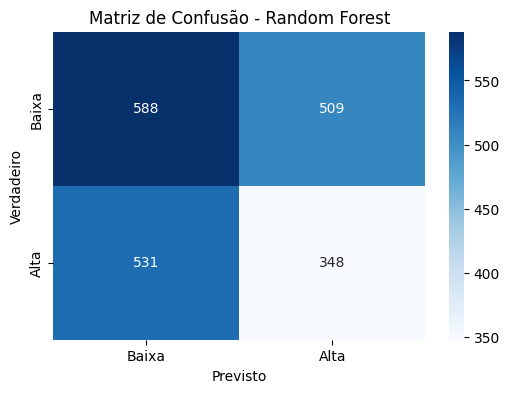

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

       Baixa       0.53      0.54      0.53      1097
        Alta       0.41      0.40      0.40       879

    accuracy                           0.47      1976
   macro avg       0.47      0.47      0.47      1976
weighted avg       0.47      0.47      0.47      1976



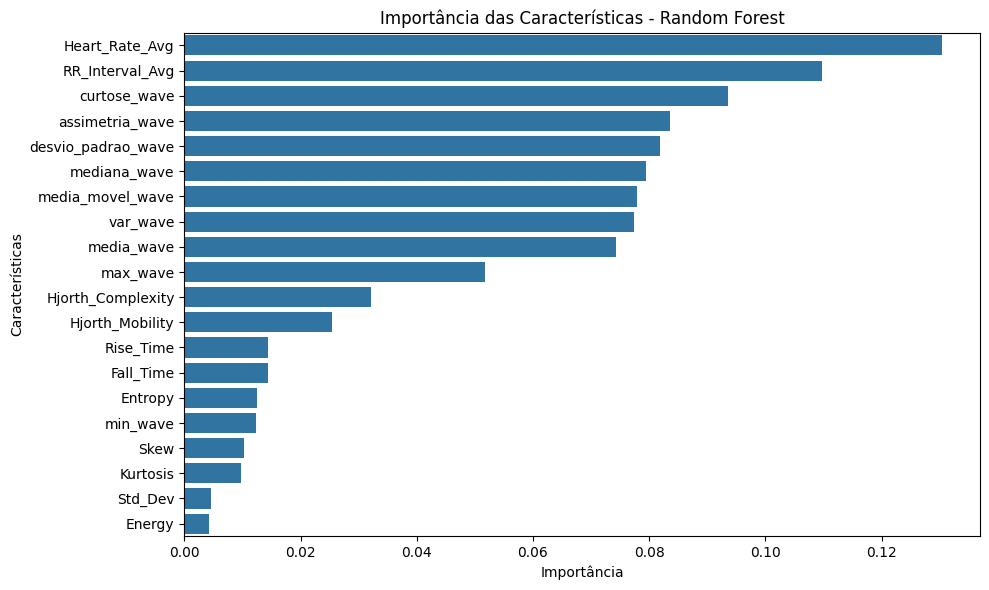

Acurácia do modelo Naive Bayes: 49.39%


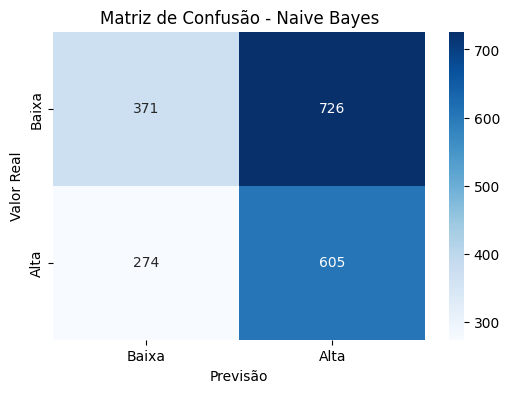

Relatório de Classificação - Naive Bayes:
              precision    recall  f1-score   support

       Baixa       0.58      0.34      0.43      1097
        Alta       0.45      0.69      0.55       879

    accuracy                           0.49      1976
   macro avg       0.51      0.51      0.49      1976
weighted avg       0.52      0.49      0.48      1976



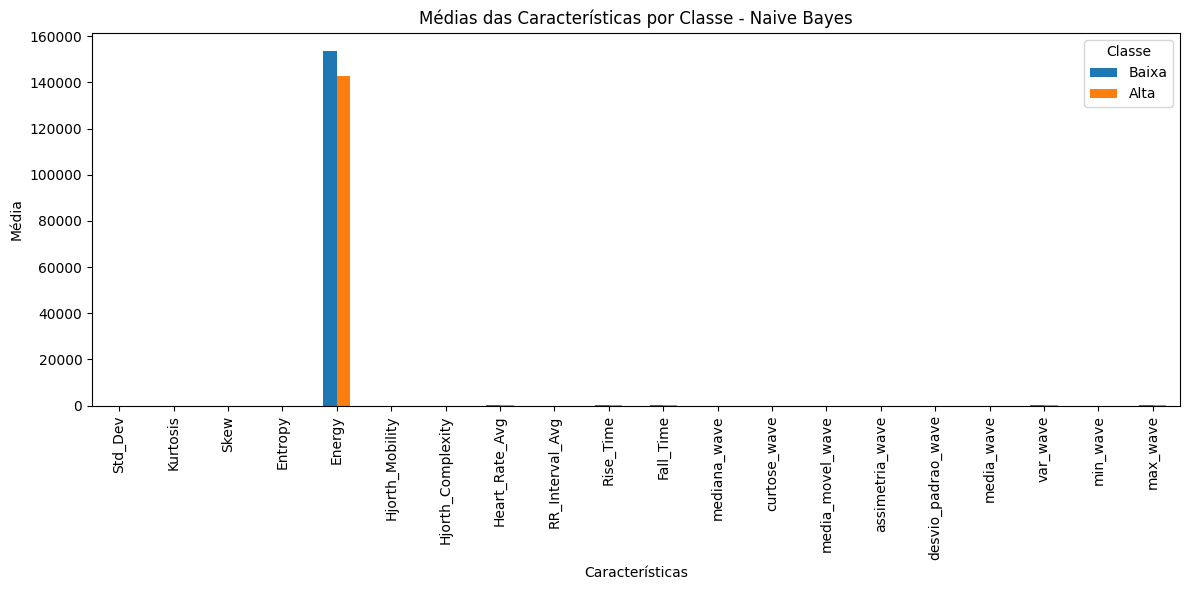

Balanced Accuracy Logistic Regression: 57.50%


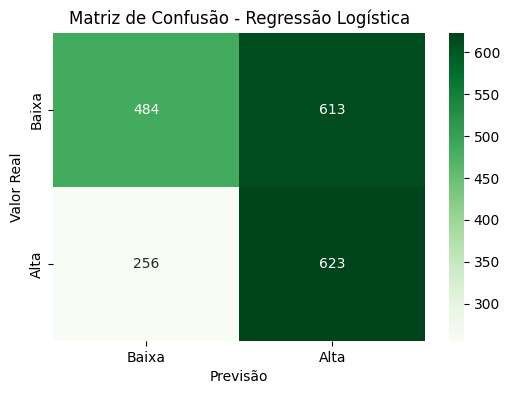

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

       Baixa       0.65      0.44      0.53      1097
        Alta       0.50      0.71      0.59       879

    accuracy                           0.56      1976
   macro avg       0.58      0.57      0.56      1976
weighted avg       0.59      0.56      0.55      1976



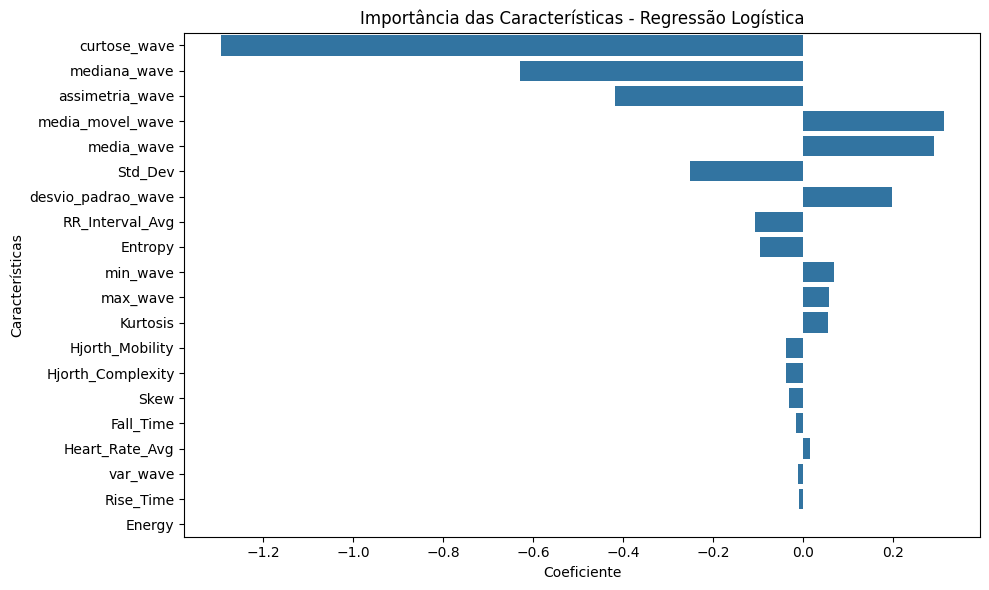

Acurácia balanceada para k-NN: 51.25%


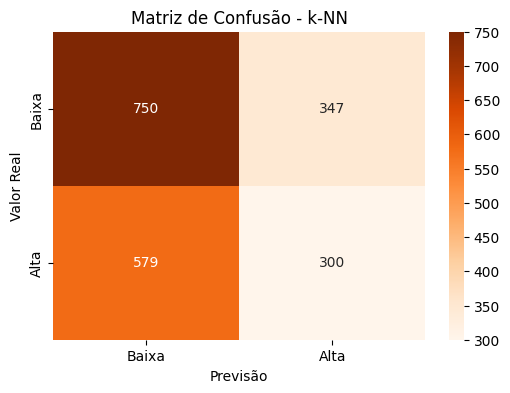

Relatório de Classificação - k-NN:
              precision    recall  f1-score   support

       Baixa       0.56      0.68      0.62      1097
        Alta       0.46      0.34      0.39       879

    accuracy                           0.53      1976
   macro avg       0.51      0.51      0.51      1976
weighted avg       0.52      0.53      0.52      1976



In [ ]:
# Plotar a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# Exibir Relatório de Classificação
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Baixa', 'Alta']))



# Plotar a Importância das Características
importances = clf_rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Características': feature_names, 'Importância': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Características', data=feature_importance_df)
plt.title('Importância das Características - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# Previsões no conjunto de teste para Naive Bayes
y_pred_nb = model_nb.predict(X_test)

accuracy_nb = model_nb.score(X_test, y_test)
print(f'Acurácia do modelo Naive Bayes: {accuracy_nb * 100:.2f}%')

# Calcular a matriz de confusão
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

# Exibir relatório de classificação
print("Relatório de Classificação - Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=['Baixa', 'Alta']))

# Importância das Características - Naive Bayes
feature_names = X.columns
theta = model_nb.theta_  # Médias das características condicionadas a cada classe

# Criar um DataFrame com as médias
feature_importance_nb = pd.DataFrame(theta, columns=feature_names)
feature_importance_nb['Classe'] = ['Baixa', 'Alta']

# Transpor o DataFrame para facilitar a plotagem
feature_importance_nb = feature_importance_nb.set_index('Classe').T

# Plotar as médias das características por classe
feature_importance_nb.plot(kind='bar', figsize=(12, 6))
plt.title('Médias das Características por Classe - Naive Bayes')
plt.xlabel('Características')
plt.ylabel('Média')
plt.legend(title='Classe')
plt.tight_layout()
plt.show()

balanced_accuracy_logit = balanced_accuracy_score(y_test, y_pred_logit)
print(f'Balanced Accuracy Logistic Regression: {balanced_accuracy_logit * 100:.2f}%')

# Calcular a matriz de confusão
cm_logit = confusion_matrix(y_test, y_pred_logit)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logit, annot=True, fmt='d', cmap='Greens', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

# Exibir relatório de classificação
print("Relatório de Classificação - Regressão Logística:")
print(classification_report(y_test, y_pred_logit, target_names=['Baixa', 'Alta']))

# Importância das Características - Regressão Logística
coefficients = clf_logit.coef_[0]
feature_names = X.columns

# Criar um DataFrame com os coeficientes
feature_importance_logit = pd.DataFrame({'Características': feature_names, 'Coeficiente': coefficients})

# Calcular o valor absoluto dos coeficientes
feature_importance_logit['Coeficiente_Abs'] = feature_importance_logit['Coeficiente'].abs()

# Ordenar por importância
feature_importance_logit = feature_importance_logit.sort_values(by='Coeficiente_Abs', ascending=False)

# Plotar as importâncias das características
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Características', data=feature_importance_logit)
plt.title('Importância das Características - Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

acc_knn = balanced_accuracy_score(y_test, y_pred_knn)
print(f"Acurácia balanceada para k-NN: {acc_knn * 100:.2f}%")

# Calcular a matriz de confusão
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão - k-NN')
plt.show()

# Exibir relatório de classificação
print("Relatório de Classificação - k-NN:")
print(classification_report(y_test, y_pred_knn, target_names=['Baixa', 'Alta']))

# Importância das Características - k-NN (Permutation Importance)
from sklearn.inspection import permutation_importance

# Calcular a importância por permutação
result = permutation_importance(clf_knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Criar um DataFrame com as importâncias
feature_importance_knn = pd.DataFrame({'Características': X.columns, 'Importância': result.importances_mean})
feature_importance_knn = feature_importance_knn.sort_values(by='Importância', ascending=False)

# Plotar as importâncias das características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Características', data=feature_importance_knn)
plt.title('Importância das Características - k-NN (Permutation Importance)')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


**CN2**

In [ ]:
# Definir o domínio (features e target)
domain = Orange.data.Domain(
    [Orange.data.ContinuousVariable(name) for name in X_train.columns],
    Orange.data.DiscreteVariable('Glicose_Alta', values=['Baixa', 'Alta'])  # Ajuste os nomes conforme necessário
)

# Criar tabelas do Orange
train_data = Orange.data.Table(domain, X_train.values, y_train.values.reshape(-1, 1))
test_data = Orange.data.Table(domain, X_test.values, y_test.values.reshape(-1, 1))

# Treinar o modelo CN2
learner_cn2 = Orange.classification.rules.CN2Learner()
clf_cn2 = learner_cn2(train_data)

# Fazer previsões com o modelo CN2
y_pred_cn2 = [clf_cn2(x) for x in test_data]

# Calcular a acurácia balanceada
acc_cn2 = balanced_accuracy_score(y_test, y_pred_cn2)
print(f"Acurácia balanceada para CN2: {acc_cn2 * 100:.2f}%")

# Matriz de confusão do CN2
cm_cn2 = confusion_matrix(y_test, y_pred_cn2)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cn2, annot=True, fmt='d', cmap='Purples', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão - CN2')
plt.show()

for rule in clf_cn2.rule_list:
    print(rule)
# Exibir relatório de classificação
print("Relatório de Classificação - CN2:")
print(classification_report(y_test, y_pred_cn2, target_names=['Baixa', 'Alta']))

model_accuracies = {
    'Naive Bayes': accuracy_nb,
    'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    'k-Nearest Neighbors (k=100)': acc_knn,
    'Random Forest (estimator|states=100|42)': acc_rf,
    'CN2': acc_cn2
}

plot_model_accuracy_vs_100(model_accuracies)

**---------------------------------------OTIMIZANDO PARAMETROS---------------------------**

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       682
           1       0.99      0.98      0.99       606

    accuracy                           0.99      1288
   macro avg       0.99      0.99      0.99      1288
weighted avg       0.99      0.99      0.99      1288

Confusion Matrix:
[[677   5]
 [ 12 594]]


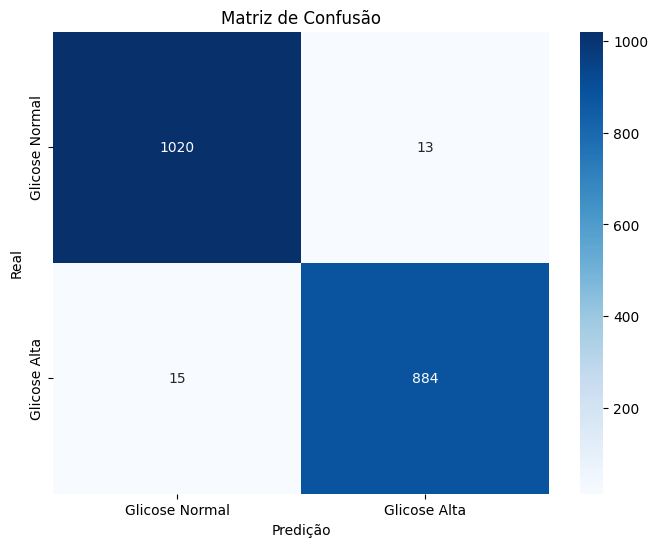

Melhores Parâmetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Melhor Pontuação: 0.9879611650485437
Balanced Accuracy Random Forest (otimizado): 98.54%


<ipython-input-8-80da46134744>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=params, y=values, palette='viridis')


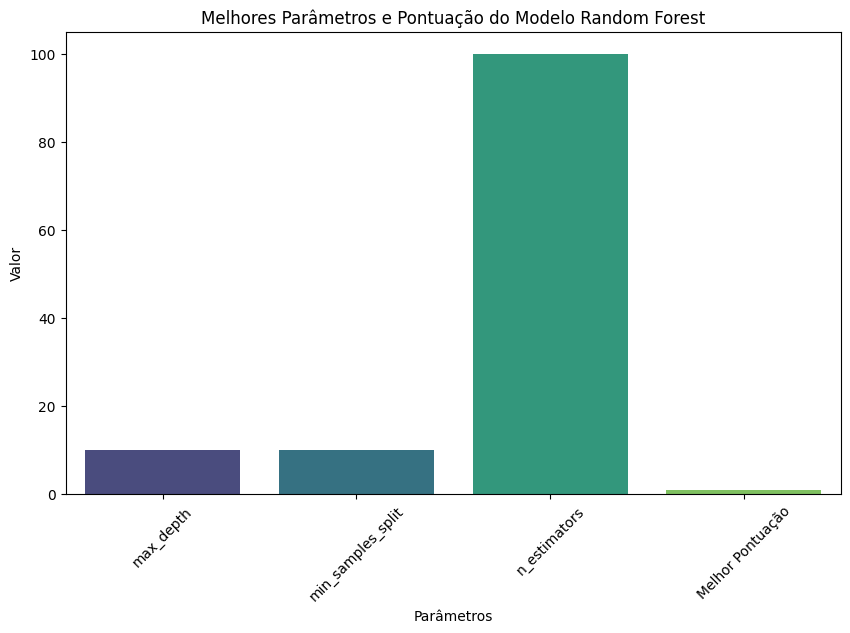

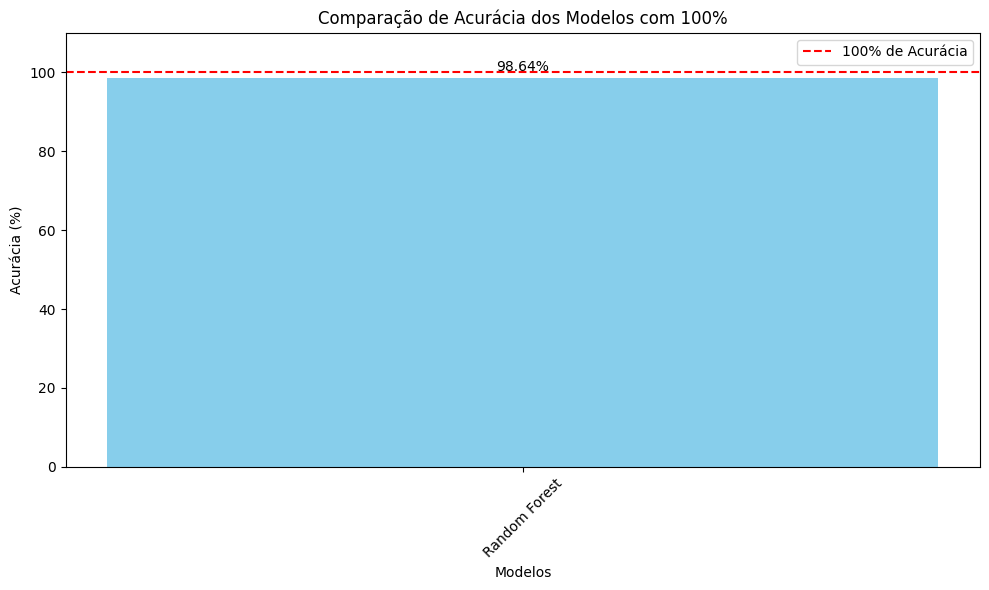

In [ ]:

# --- Implementação da Otimização de Parâmetros ---

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Remover quaisquer linhas com valores nulos
final_data_clean = final_data.dropna()

# Separar features e target
X = final_data_clean.drop(['Patient_ID', 'Glicose_Alta'], axis=1)
y = final_data_clean['Glicose_Alta']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir o modelo
rf = RandomForestClassifier(random_state=42)

# Definir o grid de hiperparâmetros para otimização
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy')

# Treinar o modelo com a otimização de hiperparâmetros
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf = grid_search.best_estimator_

# Previsões no conjunto de teste
y_pred = best_rf.predict(X_test)

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Glicose Normal', 'Glicose Alta'], yticklabels=['Glicose Normal', 'Glicose Alta'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

# Imprimir os melhores parâmetros e a pontuação correspondente
print("Melhores Parâmetros:", grid_search.best_params_)
print("Melhor Pontuação:", grid_search.best_score_)

acc_rf_best = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Random Forest (otimizado): {acc_rf * 100:.2f}%")

# --- Gráfico de Barras para os Melhores Parâmetros e Pontuação ---
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Criar dados para o gráfico
params = list(best_params.keys())
values = list(best_params.values())

# Adicionando a pontuação ao final
params.append('Melhor Pontuação')
values.append(best_score)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=params, y=values, palette='viridis')
plt.title('Melhores Parâmetros e Pontuação do Modelo Random Forest')
plt.xlabel('Parâmetros')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

model_accuracies_otimization = {
    #'Naive Bayes': accuracy_nb,
    #'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    #'k-Nearest Neighbors (k=100)': acc_knn,
    #'Random Forest (estimator|states=100|42)': acc_rf,
    #'CN2': acc_cn2
    'Random Forest': acc_rf_best
}

plot_model_accuracy_vs_100(model_accuracies_otimization)

**ALTERNATIVO**

               Feature  Importance
7       Heart_Rate_Avg    0.137897
8      RR_Interval_Avg    0.119809
12        curtose_wave    0.085690
13    media_movel_wave    0.077320
11        mediana_wave    0.076761
14     assimetria_wave    0.074424
15  desvio_padrao_wave    0.069323
16          media_wave    0.067421
17            var_wave    0.066456
19            max_wave    0.052499
18            min_wave    0.040373
6    Hjorth_Complexity    0.027666
5      Hjorth_Mobility    0.026279
10           Fall_Time    0.025506
9            Rise_Time    0.016142
3              Entropy    0.011546
2                 Skew    0.011132
1             Kurtosis    0.009276
0              Std_Dev    0.002455
4               Energy    0.002024


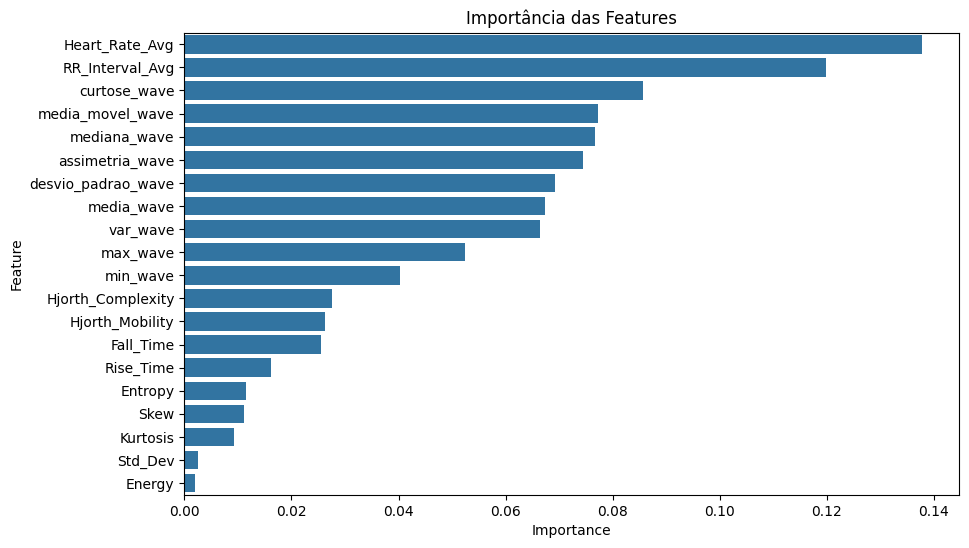

Features selecionadas:
7         Heart_Rate_Avg
8        RR_Interval_Avg
12          curtose_wave
13      media_movel_wave
11          mediana_wave
14       assimetria_wave
15    desvio_padrao_wave
16            media_wave
17              var_wave
Name: Feature, dtype: object
Classification Report after Feature Selection:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       682
           1       1.00      0.98      0.99       606

    accuracy                           0.99      1288
   macro avg       0.99      0.99      0.99      1288
weighted avg       0.99      0.99      0.99      1288

Confusion Matrix after Feature Selection:
[[682   0]
 [ 12 594]]
Balanced Accuracy Random Forest (otimizado): 99.01%


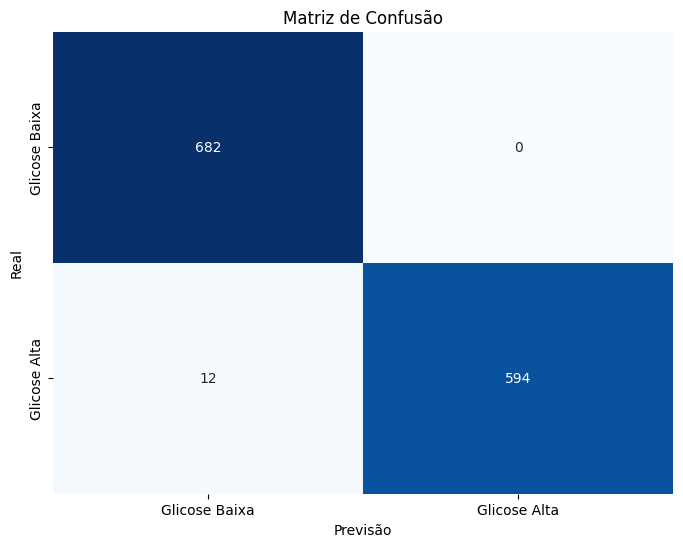

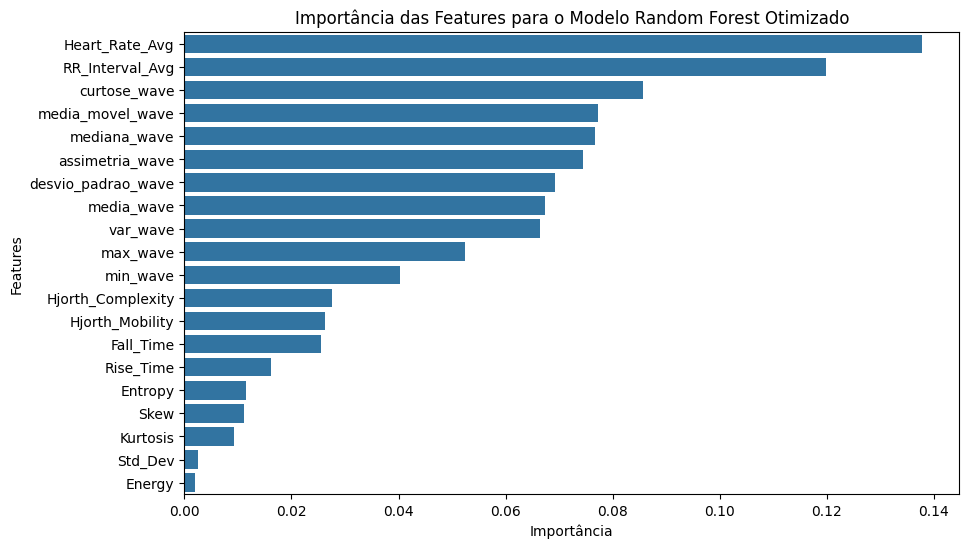

<ipython-input-78-48a9e7ae2f28>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=selected_importances, palette='viridis')


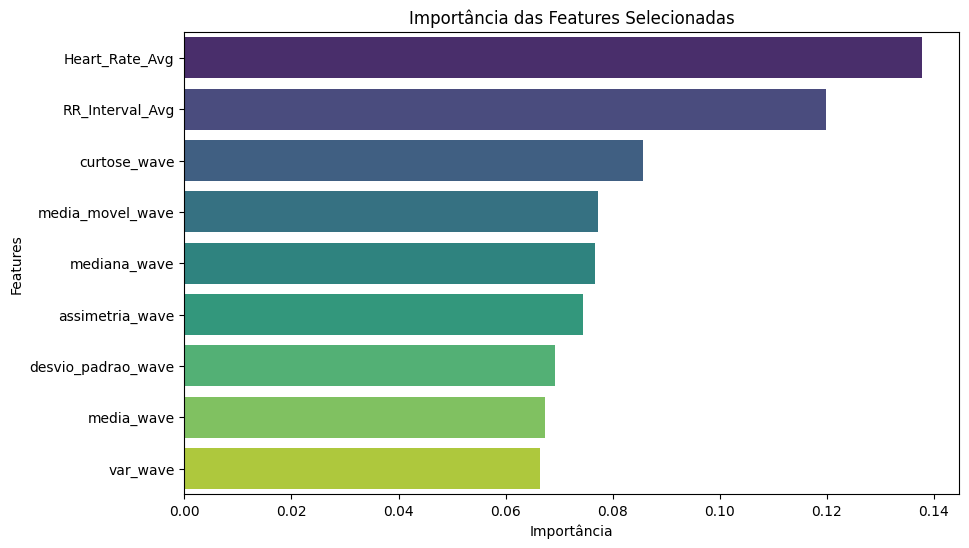

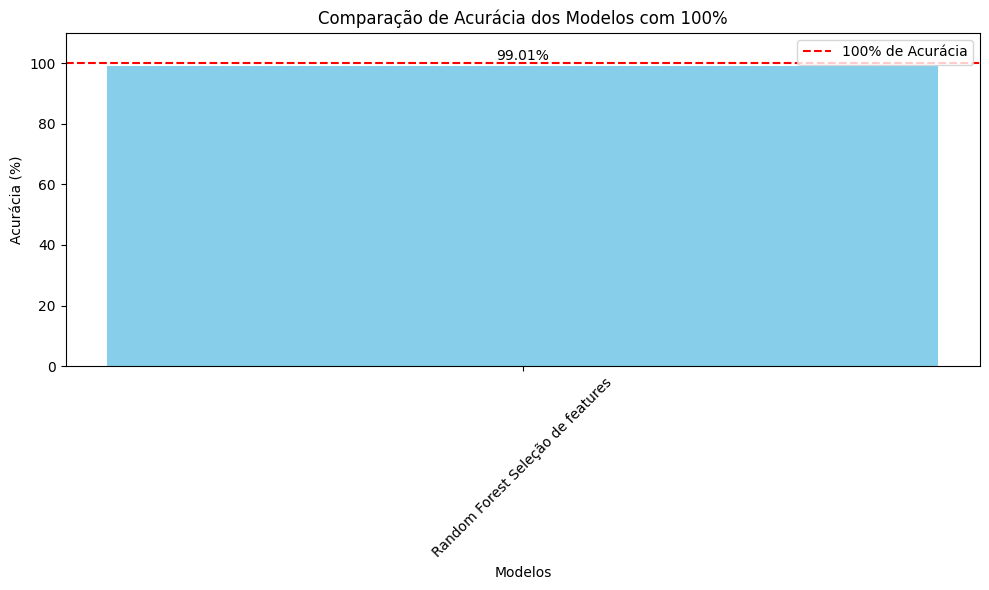

In [ ]:
# Treinar o modelo final com todos os dados de treinamento
best_rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = best_rf.feature_importances_

# Criar um DataFrame para visualizar as importâncias
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar por importância
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

# Plotar as importâncias
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


# Definir o limiar
threshold = 0.06

# Selecionar as features com importância maior que o limiar
selected_features = importances_df[importances_df['Importance'] > threshold]['Feature']

print("Features selecionadas:")
print(selected_features)

# Atualizar X_train e X_test com as features selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Treinar o modelo com as features selecionadas
best_rf.fit(X_train_selected, y_train)

# Fazer previsões
y_pred_selected = best_rf.predict(X_test_selected)

# Avaliar o modelo
print("Classification Report after Feature Selection:")
print(classification_report(y_test, y_pred_selected))

print("Confusion Matrix after Feature Selection:")
print(confusion_matrix(y_test, y_pred_selected))

acc_rf_selecao_alt = balanced_accuracy_score(y_test, y_pred_selected)
print(f"Balanced Accuracy Random Forest (otimizado): {acc_rf_selecao_alt * 100:.2f}%")

# --- Plotar a Matriz de Confusão ---
conf_matrix = confusion_matrix(y_test, y_pred_selected)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Glicose Baixa', 'Glicose Alta'],
            yticklabels=['Glicose Baixa', 'Glicose Alta'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# --- Importância das Features para o Modelo `best_rf` ---
# Obter a importância das features
feature_importances = best_rf.feature_importances_

# Criar um DataFrame para visualizar as importâncias
importances_dfalt = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': feature_importances
})

# Ordenar por importância
importances_dfalt = importances_df.sort_values(by='Importance', ascending=False)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_dfalt)
plt.title('Importância das Features para o Modelo Random Forest Otimizado')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

# --- Gráfico de Importância das Features Selecionadas ---
# Obter a importância das features selecionadas
selected_importances = importances_dfalt[importances_dfalt['Feature'].isin(selected_features)]

# Plotar as importâncias das features selecionadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=selected_importances, palette='viridis')
plt.title('Importância das Features Selecionadas')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

model_accuracies_otimization_2 = {
    #'Naive Bayes': accuracy_nb,
    #'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    #'k-Nearest Neighbors (k=100)': acc_knn,
    #'Random Forest (estimator|states=100|42)': acc_rf,
    #'CN2': acc_cn2,
    #'Random Forest Grid': acc_rf_best,
    'Random Forest Seleção de features': acc_rf_selecao_alt
}

plot_model_accuracy_vs_100(model_accuracies_otimization_2)

**COMPARANDO RESULTADOS**

**RFE RANDOM FOREST**

Features selecionadas pelo RFE:
Index(['Heart_Rate_Avg', 'RR_Interval_Avg', 'curtose_wave', 'media_wave'], dtype='object')
Classification Report after RFE:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       682
           1       1.00      0.98      0.99       606

    accuracy                           0.99      1288
   macro avg       0.99      0.99      0.99      1288
weighted avg       0.99      0.99      0.99      1288

Confusion Matrix after RFE:
[[682   0]
 [ 12 594]]
Balanced Accuracy Random Forest (otimizado): 99.01%


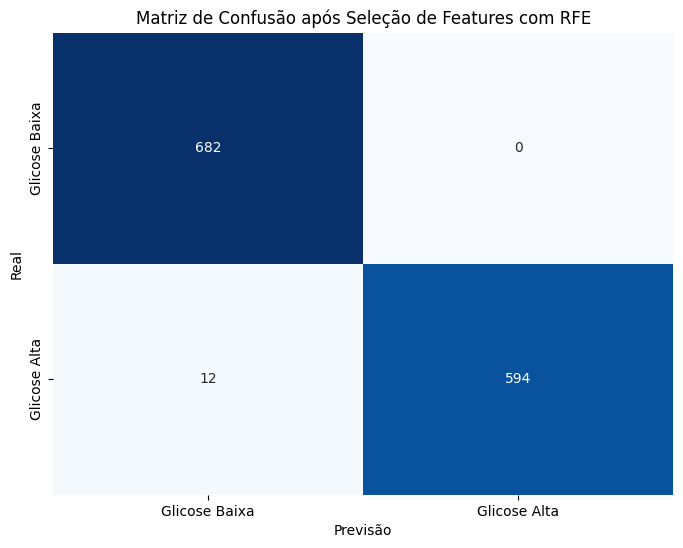

<ipython-input-79-4b1a0710c3e6>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df_rfe, palette='viridis')


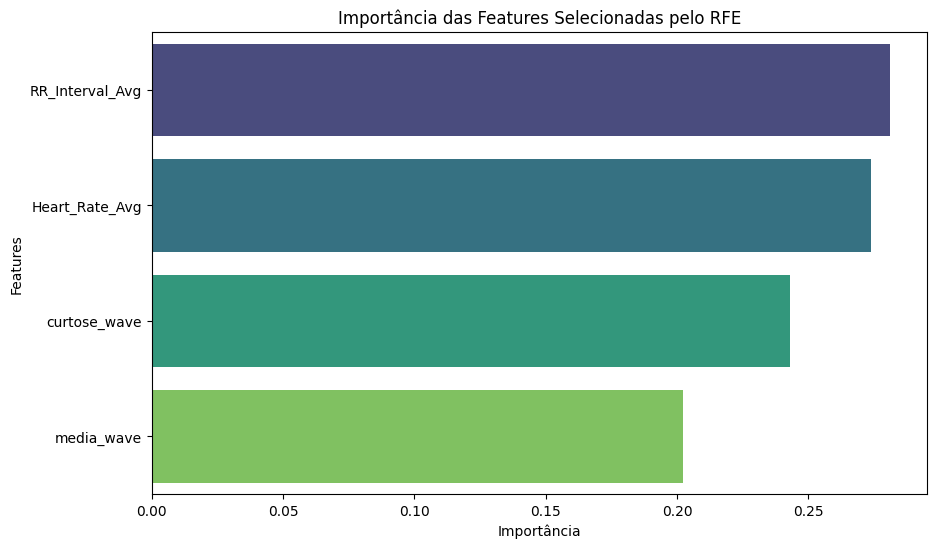

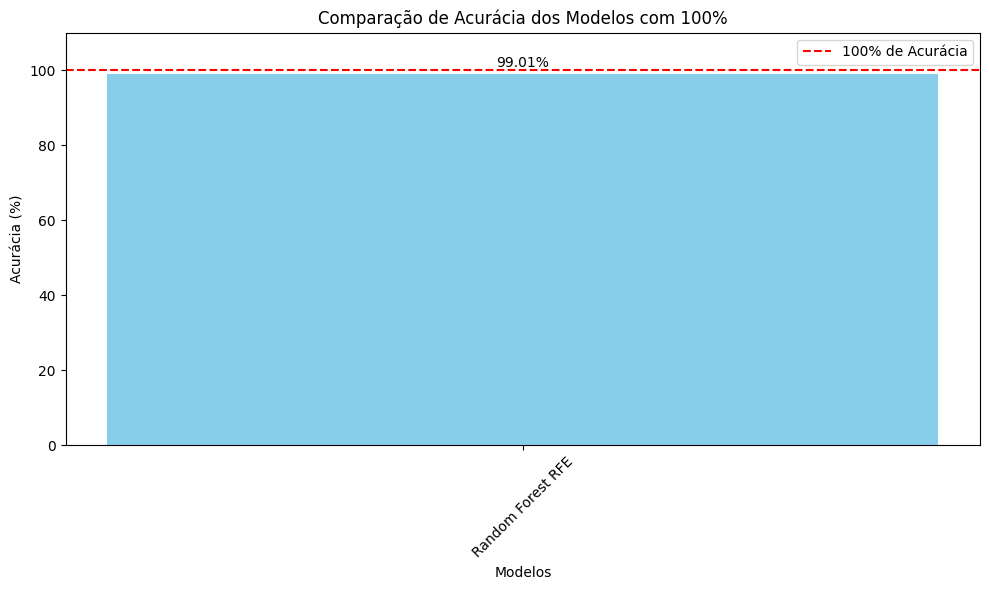

In [ ]:
from sklearn.feature_selection import RFE

# Definir o modelo base
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Definir o RFE
n_features_to_select = 4  # Número de features que queremos selecionar
rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select)

# Ajustar o RFE nos dados de treinamento
rfe.fit(X_train, y_train)

# Obter as features selecionadas
selected_features_rfe = X_train.columns[rfe.support_]

print("Features selecionadas pelo RFE:")
print(selected_features_rfe)

# Atualizar X_train e X_test com as features selecionadas
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Treinar o modelo com as features selecionadas
rf.fit(X_train_rfe, y_train)

# Fazer previsões
y_pred_rfe = rf.predict(X_test_rfe)

# Avaliar o modelo
print("Classification Report after RFE:")
print(classification_report(y_test, y_pred_rfe))

print("Confusion Matrix after RFE:")
print(confusion_matrix(y_test, y_pred_rfe))

acc_rf_rfe = balanced_accuracy_score(y_test, y_pred_rfe)
print(f"Balanced Accuracy Random Forest (otimizado): {acc_rf_rfe * 100:.2f}%")

# --- Plotar a Importância das Features selecionadas pelo RFE ---
# Obter a importância das features
# --- Plotar a Matriz de Confusão ---
conf_matrix = confusion_matrix(y_test, y_pred_rfe)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Glicose Baixa', 'Glicose Alta'],
            yticklabels=['Glicose Baixa', 'Glicose Alta'])
plt.title('Matriz de Confusão após Seleção de Features com RFE')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

feature_importances = rf.feature_importances_

# Criar um DataFrame para visualizar as importâncias
importances_df_rfe = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Importance': feature_importances
})

# Ordenar por importância
importances_df_rfe = importances_df_rfe.sort_values(by='Importance', ascending=False)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df_rfe, palette='viridis')
plt.title('Importância das Features Selecionadas pelo RFE')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()


model_accuracies_otimization_4 = {
    #'Naive Bayes': accuracy_nb,
    #'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    #'k-Nearest Neighbors (k=100)': acc_knn,
    #'Random Forest (estimator|states=100|42)': acc_rf,
    #'CN2': acc_cn2,
    #'Random Forest Grid': acc_rf_best,
    'Random Forest RFE': acc_rf_rfe
}

plot_model_accuracy_vs_100(model_accuracies_otimization_4)


**SEKECT K BEST - RANDOM FOREST**

Features selecionadas pelo SelectKBest:
Index(['Entropy', 'Hjorth_Mobility', 'Hjorth_Complexity', 'Heart_Rate_Avg',
       'RR_Interval_Avg', 'Rise_Time', 'Fall_Time', 'media_movel_wave',
       'min_wave'],
      dtype='object')
Classification Report after SelectKBest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       682
           1       0.99      0.98      0.98       606

    accuracy                           0.99      1288
   macro avg       0.99      0.99      0.99      1288
weighted avg       0.99      0.99      0.99      1288

Confusion Matrix after SelectKBest:
[[674   8]
 [ 11 595]]
Balanced Accuracy Random Forest (otimizado): 98.51%


<ipython-input-80-5432d180d657>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df_kbest, palette='viridis')


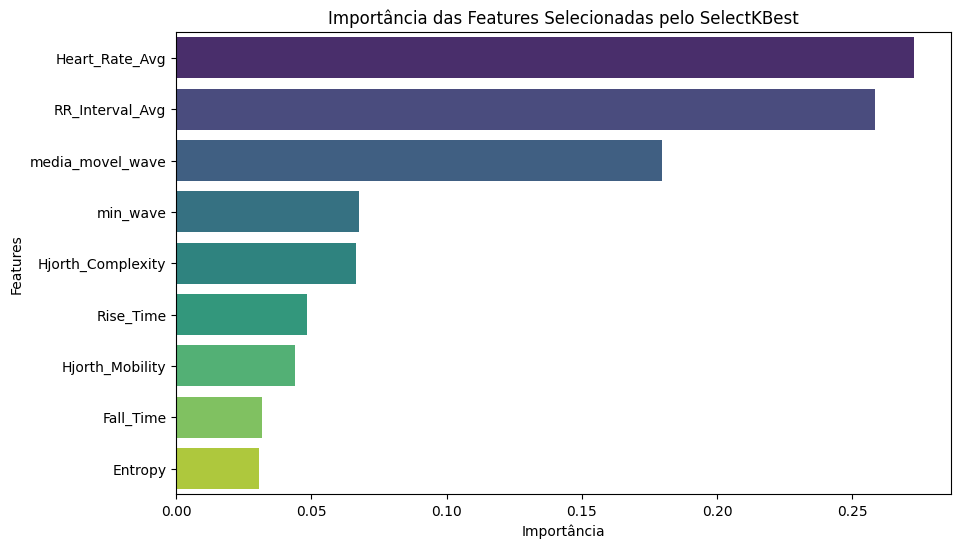

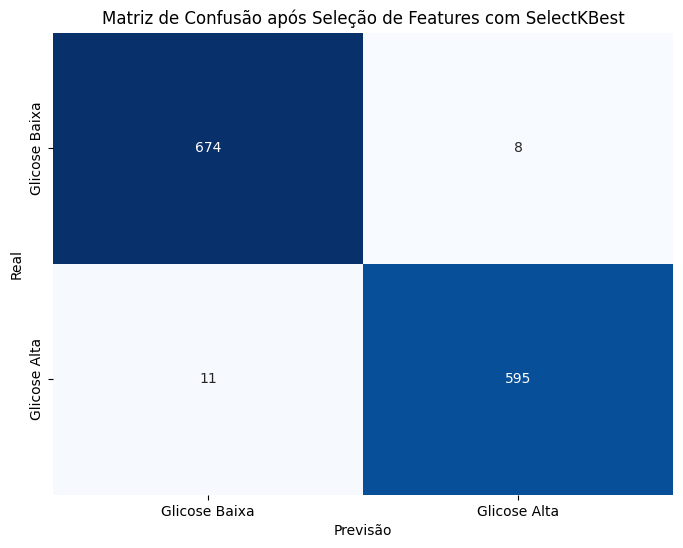

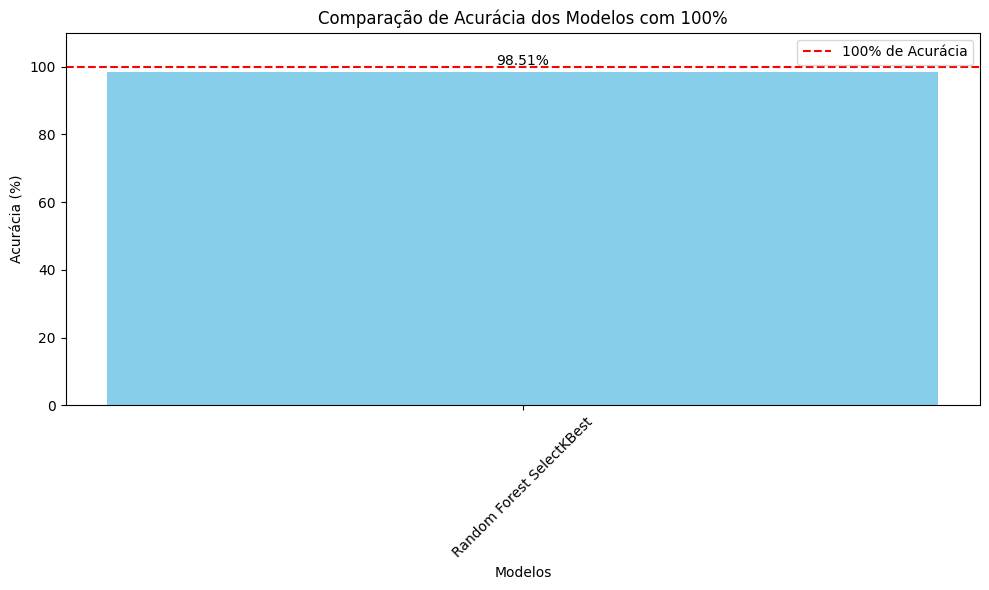

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Definir o número de features que queremos selecionar
k = 9

# Aplicar o SelectKBest
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)

# Obter as features selecionadas
selected_features_kbest = X_train.columns[selector.get_support()]

print("Features selecionadas pelo SelectKBest:")
print(selected_features_kbest)

# Atualizar X_train e X_test com as features selecionadas
X_train_kbest = X_train[selected_features_kbest]
X_test_kbest = X_test[selected_features_kbest]

# Treinar o modelo com as features selecionadas
rf.fit(X_train_kbest, y_train)

# Fazer previsões
y_pred_kbest = rf.predict(X_test_kbest)

# Avaliar o modelo
print("Classification Report after SelectKBest:")
print(classification_report(y_test, y_pred_kbest))

print("Confusion Matrix after SelectKBest:")
print(confusion_matrix(y_test, y_pred_kbest))

acc_rf_k_best = balanced_accuracy_score(y_test, y_pred_kbest)
print(f"Balanced Accuracy Random Forest (otimizado): {acc_rf_k_best * 100:.2f}%")

# --- Plotar a Importância das Features selecionadas pelo SelectKBest ---
# Obter a importância das features para as selecionadas
feature_importances_kbest = rf.feature_importances_

# Criar um DataFrame para visualizar as importâncias
importances_df_kbest = pd.DataFrame({
    'Feature': X_train_kbest.columns,
    'Importance': feature_importances_kbest
})

# Ordenar por importância
importances_df_kbest = importances_df_kbest.sort_values(by='Importance', ascending=False)

# Plotar as importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df_kbest, palette='viridis')
plt.title('Importância das Features Selecionadas pelo SelectKBest')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

# --- Plotar a Matriz de Confusão ---
conf_matrix_kbest = confusion_matrix(y_test, y_pred_kbest)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_kbest, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Glicose Baixa', 'Glicose Alta'],
            yticklabels=['Glicose Baixa', 'Glicose Alta'])
plt.title('Matriz de Confusão após Seleção de Features com SelectKBest')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

model_accuracies_otimization_3 = {
    #'Naive Bayes': accuracy_nb,
    #'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    #'k-Nearest Neighbors (k=100)': acc_knn,
    #'Random Forest (estimator|states=100|42)': acc_rf,
    #'CN2': acc_cn2,
    #'Random Forest Grid': acc_rf_best,
    #'Random Forest Seleção de features': acc_rf_selecao,
    #'Random Forest RFE': acc_rf_rfe,
    'Random Forest SelectKBest': acc_rf_k_best
}

plot_model_accuracy_vs_100(model_accuracies_otimization_3)




**COMPARANDO TODOS OS MÉTODOS**

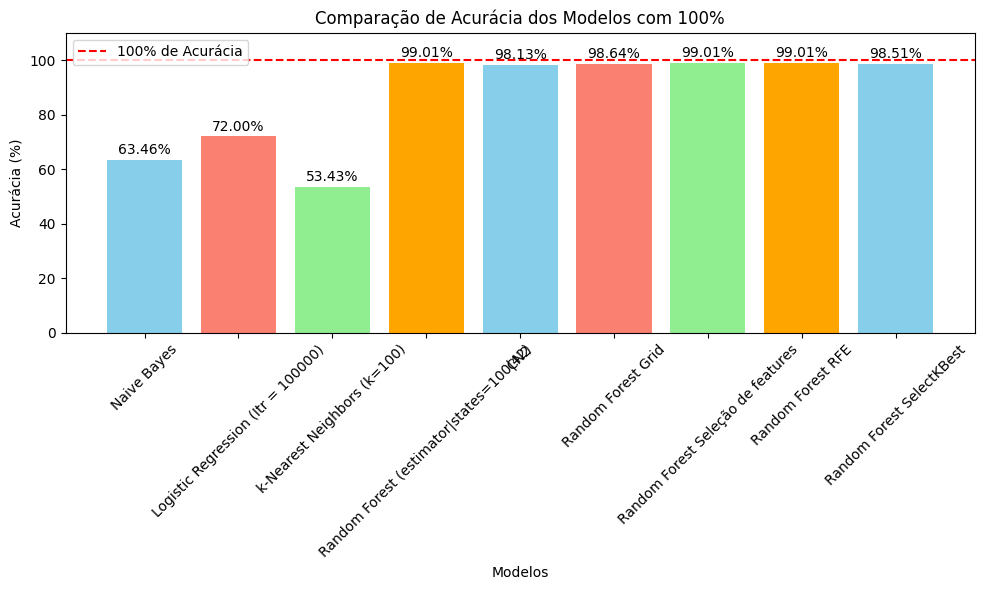

In [ ]:
model_accuracies_otimization_5 = {
    'Naive Bayes': accuracy_nb,
    'Logistic Regression (Itr = 100000)': balanced_accuracy_logit,
    'k-Nearest Neighbors (k=100)': acc_knn,
    'Random Forest (estimator|states=100|42)': acc_rf,
    'CN2': acc_cn2,
    'Random Forest Grid': acc_rf_best,
    'Random Forest Seleção de features': acc_rf_selecao_alt,
    'Random Forest RFE': acc_rf_rfe,
    'Random Forest SelectKBest': acc_rf_k_best
}

plot_model_accuracy_vs_100(model_accuracies_otimization_5)

